Name: \
Student ID:

In [1]:
try:
  from skopt import BayesSearchCV
except ImportError:
  !pip install -q scikit-optimize
  from skopt import BayesSearchCV

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split, GridSearchCV



from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.feature_selection import RFE, SelectFromModel

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Task 1: Classification
Open a new Jupyter notebook and name it etivity3_classification.ipynb. In this notebook, first of all, replace the column `insurance_cost` with a binary column `insurance_cost_binary`, where `insurance_cost_binary` is 0 if the corresponding `insurance_cost` is less than or equal to the median insurance cost and 1 otherwise. Then train three classification pipelines with SVM, Random Forest and a third classifier of your choice as the final estimator, respectively, to train a model that predicts the value of `insurance_cost_binary`.

Requirements:
* For each classifier, include data preparation and dimensionality reduction steps in the main pipeline.
* You can choose any classifier as the third one. Some options are MLPClassifier, Naive Bayes, and kNN, but you are not limited to them.
* For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique in at least one pipeline.
* Use grid search for hyperparameter tuning and replicate the process in the example notebook Tutorial 3-1 - Binary Classification.ipynb to evaluate and compare the models you have trained and pick the best one.
* Summarise your experience in a markdown cell (max 150 words in a markdown cell).

**[About Dataset](https://www.kaggle.com/datasets/mirichoi0218/insurance)**

Columns

* age: age of primary beneficiary
* gender: insurance contractor gender, female, male
* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight ($kg / m^2$) using the ratio of height to weight, ideally 18.5 to 24.9
* children: Number of children covered by health insurance / Number of dependents
* smoker: Smoking
* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
* insurance_cost: Individual medical costs billed by health insurance


In [3]:
df = pd.read_csv('insurance.csv')
df.head(4)

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635

df.describe()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   gender          1338 non-null   object 
 2   bmi             1338 non-null   float64
 3   children        1338 non-null   int64  
 4   smoker          1338 non-null   object 
 5   region          1338 non-null   object 
 6   insurance_cost  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


From the above it is clear there are no missing values

### Replace insurance cost with binary encoded values

In [5]:
median_cost =  df['insurance_cost'].median()
df['insurance_cost_binary'] = pd.Categorical(df['insurance_cost'].apply(lambda x:0 if x <=median_cost else 1))
df = df.drop(columns = ['insurance_cost'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   age                    1338 non-null   int64   
 1   gender                 1338 non-null   object  
 2   bmi                    1338 non-null   float64 
 3   children               1338 non-null   int64   
 4   smoker                 1338 non-null   object  
 5   region                 1338 non-null   object  
 6   insurance_cost_binary  1338 non-null   category
dtypes: category(1), float64(1), int64(2), object(3)
memory usage: 64.3+ KB


In [7]:
df.head(5)

age  gender     bmi  children smoker     region insurance_cost_binary
0   18    male  33.770         1     no  southeast                     0
1   18    male  34.100         0     no  southeast                     0
2   18  female  26.315         0     no  northeast                     0
3   18  female  38.665         2     no  northeast                     0
4   18  female  35.625         0     no  northeast                     0

### Prepare data set for training and test dataset

In [8]:
df_target = df['insurance_cost_binary']
df = df.drop(columns=['insurance_cost_binary'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df, df_target, test_size=0.2, random_state=42, shuffle=True, stratify=df_target )

In [10]:
X_train.head()

age  gender     bmi  children smoker     region
983    51  female  18.050         0     no  northwest
698    40    male  25.080         0     no  southeast
1173   57  female  25.740         2     no  southeast
285    25    male  30.590         0     no  northeast
302    25  female  34.485         0     no  northwest

In [11]:
y_train.head()

983     1
698     0
1173    1
285     0
302     0
Name: insurance_cost_binary, dtype: category
Categories (2, int64): [0, 1]

## EDA

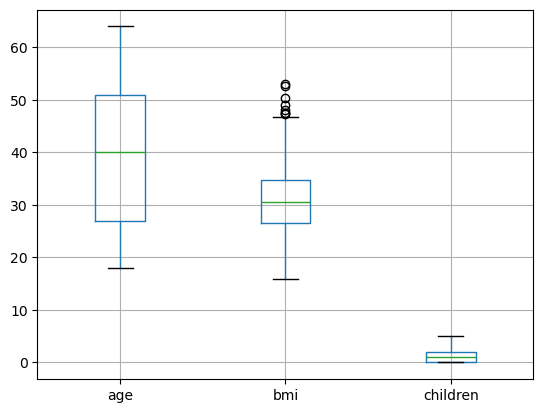

In [12]:
X_train.boxplot()
plt.show()

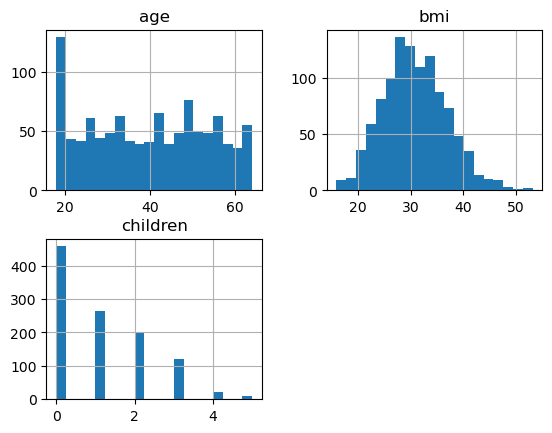

In [13]:
X_train.hist(bins=20)
plt.show()

In [14]:
X_train.describe(include=['object'])

gender smoker     region
count    1070   1070       1070
unique      2      2          4
top      male     no  southeast
freq      539    857        287

Age - There is no any outliers so i will do age bins and do ordinal encoding \
BMI - Some of them can be at higher end of the BMI, i will use cuberoot transformation \
Childern - I will convert this into true/false feature \
Gender, smoker and region - I will one hot encode and drop first

In [15]:
one_hotencode_features = ['gender','smoker','region']
bmi_feature = ['bmi']
children_feature = ['children']
age_feature = ['age']

In [16]:
bmi_transform = Pipeline(steps = [('bins',KBinsDiscretizer( n_bins=10, encode='ordinal', strategy='quantile' ))])
one_hot_transform =Pipeline( steps = [('onehot', OneHotEncoder(drop='first',sparse_output=False))])

In [17]:
preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("age_transform", bmi_transform, age_feature),
        ("bmi_transform", FunctionTransformer(np.cbrt), bmi_feature),
        ('children', FunctionTransformer(lambda X: X.gt(0).astype(np.uint8)), children_feature),
        ('one_hot_encode', one_hot_transform,one_hotencode_features)
    ],
)

In [18]:
sample_prep_data = preprocess_pipeline.fit_transform(X_train)
sample_prep_data.shape

(1070, 8)

### Create a generic classifier pipleine that can be used for grid search

In [19]:
class ClfSwitcher(BaseEstimator):
    def __init__(self, estimator = SVC()):
        self.estimator = estimator
    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self
    def predict(self, X, y=None):
        return self.estimator.predict(X)
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    def decision_function(self, X):
        return self.estimator.decision_function(X)
    def score(self, X, y):
        return self.estimator.score(X, y)

In [20]:
classifer_pipline = Pipeline(steps=[('preprocess', preprocess_pipeline),
                                    ('reduce_dim', 'passthrough'),
                                    ('classifier', ClfSwitcher())
                                   ])

In [22]:
classifer_pipline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('age_transform',
                                                  Pipeline(steps=[('bins',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=10))]),
                                                  ['age']),
                                                 ('bmi_transform',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['bmi']),
                                                 ('children',
                                                  FunctionTransformer(func=<function <lambda> at 0x000001CDD6F26E80>),
                                                  ['children']),
                                                 ('one_hot_encode',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('reduce_dim', 'passthrough'), ('classifier', ClfSwitcher())])

## SVC classifer

Train a SVC classifier with different feature selection techiques and see what is the best

In [23]:
N_FEATURES_OPTIONS = [2, 4, None]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
SVC_C = [0.1, 1, 10, 100]
SVC_GAMMA = [1, 0.1, 0.01, 0.001]
SVC_KERNEL = ['rbf', 'linear', 'poly']
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classifier__estimator': [SVC(probability=True)],
        'classifier__estimator__C': SVC_C,
        'classifier__estimator__gamma':SVC_GAMMA,
        'classifier__estimator__kernel':SVC_KERNEL
    },
    {
        'reduce_dim': [RFE(LogisticRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'classifier__estimator': [SVC(probability=True)],
        'classifier__estimator__C': SVC_C,
        'classifier__estimator__gamma':SVC_GAMMA,
        'classifier__estimator__kernel':SVC_KERNEL
    },
    {
        'reduce_dim': [SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False))],
        'reduce_dim__max_features': N_FEATURES_OPTIONS,
        'classifier__estimator': [SVC(probability=True)],
        'classifier__estimator__C': SVC_C,
        'classifier__estimator__gamma':SVC_GAMMA,
        'classifier__estimator__kernel':SVC_KERNEL
    }
]

In [24]:
svc_search = BayesSearchCV(classifer_pipline, param_grid, n_jobs=-1, cv=5,
                          refit=True, verbose=3)

In [26]:
np.int = np.int8

In [27]:
svc_search.fit(X_train, y_train,)
print("Best CV score = %0.3f:" % svc_search.best_score_)
print("Best parameters: ", svc_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [28]:
svc_best_model = svc_search.best_estimator_
svc_best_param = svc_search.best_params_

##

In [29]:
svc_best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('age_transform',
                                                  Pipeline(steps=[('bins',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=10))]),
                                                  ['age']),
                                                 ('bmi_transform',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['bmi']),
                                                 ('children',
                                                  FunctionTransformer(func=<function <lambda> at 0x000001CDD6F26E80>),
                                                  ['children']),
                                                 ('one_hot_encode',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('reduce_dim', PCA(iterated_power=7)),
                ('classifier',
                 ClfSwitcher(estimator=SVC(C=100.0, gamma=0.01,
                                           probability=True)))])

## Random Forest classifer

Train a Random Forest classifier with different feature selection techiques and see what is the best

In [30]:
N_FEATURES_OPTIONS = [2, 4, None]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
RFC_num_estimators = [10, 20, 50, 100]
RFC_criterion = ['gini', 'entropy', 'log_loss']
rfc_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classifier__estimator': [RandomForestClassifier()],
        'classifier__estimator__n_estimators': RFC_num_estimators,
        'classifier__estimator__max_depth':MAX_DEPTH_OPTIONS,
        'classifier__estimator__criterion':RFC_criterion
    },
    {
        'reduce_dim': [RFE(LogisticRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'classifier__estimator': [RandomForestClassifier()],
        'classifier__estimator__n_estimators': RFC_num_estimators,
        'classifier__estimator__max_depth':MAX_DEPTH_OPTIONS,
        'classifier__estimator__criterion':RFC_criterion
    },
    {
        'reduce_dim': [SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False))],
        'reduce_dim__max_features': N_FEATURES_OPTIONS,
        'classifier__estimator': [RandomForestClassifier()],
        'classifier__estimator__n_estimators': RFC_num_estimators,
        'classifier__estimator__max_depth':MAX_DEPTH_OPTIONS,
        'classifier__estimator__criterion':RFC_criterion
    }
]

In [31]:
rfc_search = BayesSearchCV(classifer_pipline, rfc_param_grid, n_jobs=-1, cv=5,
                          refit=True, verbose=3)

In [32]:
rfc_search.fit(X_train, y_train,)
print("Best CV score = %0.3f:" % rfc_search.best_score_)
print("Best parameters: ", rfc_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best CV score = 0.935:
Best parameters:  OrderedDict([('classifier__estimator', RandomForestClassifier()), ('classifier__estimator__criterion', 'log_loss'), ('classifier__estimator__max_depth', 8), ('classifier__estimator__n_estimators', 10), ('reduce_dim', PCA(iterated_power=7)), ('reduce_dim__n_components', None)])


In [33]:
rfc_best_model = rfc_search.best_estimator_
rfc_best_param = rfc_search.best_params_

In [34]:
rfc_best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('age_transform',
                                                  Pipeline(steps=[('bins',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=10))]),
                                                  ['age']),
                                                 ('bmi_transform',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['bmi']),
                                                 ('children',
                                                  FunctionTransformer(func=<function <lambda> at 0x000001CDD6F26E80>),
                                                  ['children']),
                                                 ('one_hot_encode',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('reduce_dim', PCA(iterated_power=7)),
                ('classifier',
                 ClfSwitcher(estimator=RandomForestClassifier(criterion='log_loss',
                                                              max_depth=8,
                                                              n_estimators=10)))])

## Gaussian Naive Bayes

For the 3rd classifier i will use Gaussian Naive Base classifier.

In [35]:
N_FEATURES_OPTIONS = [2, 4, None]


gnb_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classifier__estimator': [GaussianNB()]
    },
    {
        'reduce_dim': [RFE(LogisticRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'classifier__estimator': [GaussianNB()]
    },
    {
        'reduce_dim': [SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False))],
        'reduce_dim__max_features': N_FEATURES_OPTIONS,
        'classifier__estimator': [GaussianNB()]
    }
]

In [36]:
gnb_search = BayesSearchCV(classifer_pipline, gnb_param_grid, n_jobs=-1, cv=5,
                          refit=True, verbose=3)

In [37]:
gnb_search.fit(X_train, y_train,)
print("Best CV score = %0.3f:" % gnb_search.best_score_)
print("Best parameters: ", gnb_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\reddy_r\AppData\Local\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best CV score = 0.893:
Best parameters:  OrderedDict([('classifier__estimator', GaussianNB()), ('reduce_dim', PCA(iterated_power=7)), ('reduce_dim__n_components', None)])


In [38]:
gnb_best_model = gnb_search.best_estimator_
gnb_best_param = gnb_search.best_params_
gnb_best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('age_transform',
                                                  Pipeline(steps=[('bins',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=10))]),
                                                  ['age']),
                                                 ('bmi_transform',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['bmi']),
                                                 ('children',
                                                  FunctionTransformer(func=<function <lambda> at 0x000001CDD6F26E80>),
                                                  ['children']),
                                                 ('one_hot_encode',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('reduce_dim', PCA(iterated_power=7)),
                ('classifier', ClfSwitcher(estimator=GaussianNB()))])

## Compare Classification Models on Test Set

In [39]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [40]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]

    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)

    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)

    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])

    # compute fpr and tpr values for various thresholds
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)

    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])

    # compute the area under the curve
    _auc = auc(_fpr, _tpr)

    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [41]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, svc_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, rfc_best_model)
NB_accuracy, NB_precision, NB_recall, NB_f1_score, NB_tpr, NB_auc = evaluate_model(X_test, y_test, gnb_best_model)

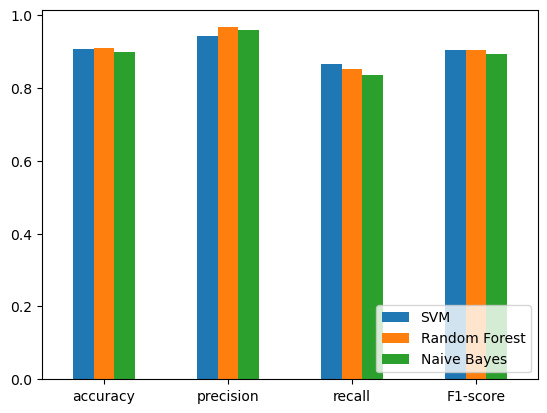

In [42]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
NB_metrics = np.array([NB_accuracy, NB_precision, NB_recall, NB_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'Naive Bayes':NB_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

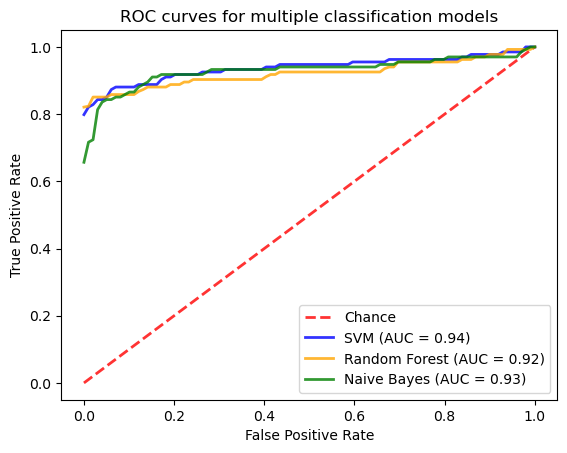

In [43]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, NB_tpr[0,:], lw=2, color='green', label='Naive Bayes (AUC = %0.2f)' % (NB_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()

In [49]:
from sklearn.base import  ClassifierMixin
from skopt.space import Real, Categorical, Integer
from sklearn.neural_network import MLPClassifier

In [81]:
class MLPWrapper(BaseEstimator, ClassifierMixin):
    
    def __init__(self, layer1=10, layer2=10, layer3=10, activation='relu', 
                 solver='adam', alpha=0.0001,
                 learning_rate='constant', learning_rate_init=0.001,
                 max_iter=1000, random_state=None
                ):
        self.layer1 = layer1
        self.layer2 = layer2
        self.layer3 = layer3
        self.activation = activation
        self.solver = solver
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X, y):
        model = MLPClassifier(
            hidden_layer_sizes=[self.layer1, self.layer2, self.layer3],
            activation = self.activation,
            solver = self.solver,
            alpha = self.alpha,
            learning_rate = self.learning_rate,
            learning_rate_init = self.learning_rate_init,
            max_iter = self.max_iter,
            random_state = self.random_state
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)
        
    def predict_proba(self, X):
        return self.model.predict_proba(X)

In [82]:
NN_search_space = {
    'layer1': Integer(4, 8),
    'layer2': Integer(1, 16),
    'layer3': Integer(1, 32),
    #'activation': Categorical(['tanh','relu']),
    #'solver': Categorical(['adam']),
    #'activation': Categorical(['logistic','tanh','relu']) 
    #'learning_rate': Categorical(['constant','invscaling','adaptive'])
}

In [83]:
N_FEATURES_OPTIONS = [2, 4, None]
mlp_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classifier__estimator': [MLPWrapper()],
        'classifier__estimator__layer1':Integer(4, 8),
        'classifier__estimator__layer2':Integer(1, 16),
        'classifier__estimator__layer3':Integer(1, 32)
    },
    {
        'reduce_dim': [RFE(LogisticRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'classifier__estimator': [MLPWrapper()],
        'classifier__estimator__layer1':Integer(4, 8),
        'classifier__estimator__layer2':Integer(1, 16),
        'classifier__estimator__layer3':Integer(1, 32)
    },
    {
        'reduce_dim': [SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False))],
        'reduce_dim__max_features': N_FEATURES_OPTIONS,
        'classifier__estimator': [MLPWrapper()],
        'classifier__estimator__layer1':Integer(4, 8),
        'classifier__estimator__layer2':Integer(1, 16),
        'classifier__estimator__layer3':Integer(1, 32)
    }
]

In [84]:
mlp_search = BayesSearchCV(classifer_pipline, mlp_param_grid, n_jobs=-1, cv=5,
                          refit=True, verbose=3)

In [85]:
mlp_search.fit(X_train, y_train,)
print("Best CV score = %0.3f:" % mlp_search.best_score_)
print("Best parameters: ", mlp_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [86]:
mlp_best_model = mlp_search.best_estimator_
mlp_best_param = mlp_search.best_params_
mlp_best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('age_transform',
                                                  Pipeline(steps=[('bins',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=10))]),
                                                  ['age']),
                                                 ('bmi_transform',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['bmi']),
                                                 ('children',
                                                  FunctionTransformer(func=<function <lambda> at 0x000001CDD6F26E80>),
                                                  ['children']),
                                                 ('one_hot_encode',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('reduce_dim', PCA(iterated_power=7)),
                ('classifier',
                 ClfSwitcher(estimator=MLPWrapper(layer1=4, layer2=4,
                                                  layer3=7)))])

In [87]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, svc_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, rfc_best_model)
NB_accuracy, NB_precision, NB_recall, NB_f1_score, NB_tpr, NB_auc = evaluate_model(X_test, y_test, gnb_best_model)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, mlp_best_model)

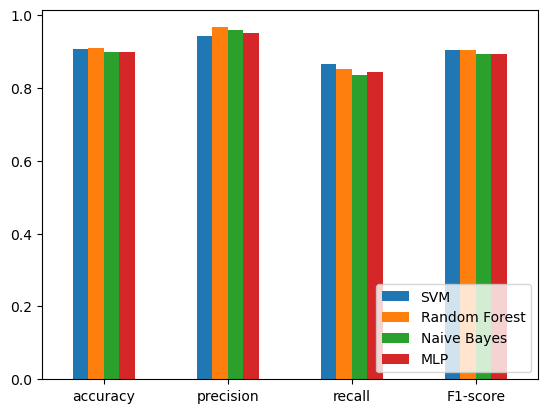

In [89]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
NB_metrics = np.array([NB_accuracy, NB_precision, NB_recall, NB_f1_score])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 
                           'Random Forest': RF_metrics, 
                           'Naive Bayes':NB_metrics,
                           'MLP':MLP_metrics
                          }, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

In [90]:
df_metrics

SVM  Random Forest  Naive Bayes       MLP
accuracy   0.906716       0.910448     0.899254  0.899254
precision  0.943089       0.966102     0.957265  0.949580
recall     0.865672       0.850746     0.835821  0.843284
F1-score   0.902724       0.904762     0.892430  0.893281

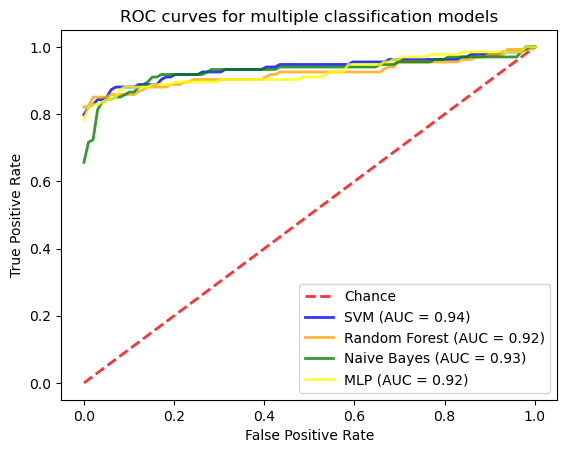

In [91]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, NB_tpr[0,:], lw=2, color='green', label='Naive Bayes (AUC = %0.2f)' % (NB_auc), alpha=0.8)
plt.plot(mean_fpr, MLP_tpr[0,:], lw=2, color='yellow', label='MLP (AUC = %0.2f)' % (MLP_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()